In [ ]:
# Install required GPU runtime for ONNX models
!pip install onnxruntime-gpu

# Install required face analysis libraries
!pip install insightface==0.7.3 deepface==0.0.95


^C


In [ ]:
!nvidia-smi
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

Sat Oct 25 13:01:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

*Download orgineel dataset van imdb-clean*


In [ ]:
import kagglehub, shutil, os, cv2

# Download dataset from Kaggle
path = kagglehub.dataset_download("yuulind/imdb-clean")

# Set target directory to store the dataset
target_dir = "/content/imdb-clean-1024"

# Copy dataset to target directory
shutil.copytree(path, target_dir, dirs_exist_ok=True)

print("✅ Dataset saved in:", target_dir)


Using Colab cache for faster access to the 'imdb-clean' dataset.
✅ Dataset saved in: /content/imdb-clean-1024


In [ ]:
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
from insightface.app import FaceAnalysis
import os
import shutil

# === Parameters ===
csv_path = "/content/imdb-clean-1024/imdb_test_new_1024.csv"
base_folder = "/content/imdb-clean-1024/imdb-clean-1024/imdb-clean-1024"
output_folder = "/content/filtered_imdb_clean_images"

limit, min_size = 1000, 1023  # Max number of images, minimum size

# === Initialize InsightFace (detection only) ===
app = FaceAnalysis(allowed_modules=["detection"])
app.prepare(ctx_id=0)  # Use GPU

# === Helper functions ===
def has_one_face(path):
    img = cv2.imread(path)
    if img is None:
        return False
    return len(app.get(img)) == 1  # True if exactly one face is detected

def get_year(fname):
    try:
        return int(fname.split("_")[-1].split(".")[0])  # Extract year from filename
    except:
        return None

# === Load and filter CSV metadata ===
df = pd.read_csv(csv_path).dropna()
df = df[(df["x_max"] > df["x_min"]) & (df["y_max"] > df["y_min"])]  # Valid bounding boxes
df = df[(df["head_yaw"].abs() < 20) & (df["head_pitch"].abs() < 20)]  # Filter by head pose
df["photo_year"] = df["filename"].apply(get_year)
df = df[df["photo_year"] > 2010].sample(frac=1, random_state=42)  # Keep only recent photos and shuffle

# === Filter and copy valid images ===
os.makedirs(output_folder, exist_ok=True)
records = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Filtering images"):
    if len(records) >= limit:
        break

    src = os.path.join(base_folder, row["filename"])
    if not os.path.exists(src):
        continue

    try:
        w, h = Image.open(src).size
    except:
        continue

    if w <= min_size and h <= min_size:
        continue
    if not has_one_face(src):
        continue

    # Copy image to output folder
    new_name = f"{len(records)+1:04d}_{os.path.basename(src)}"
    dst = os.path.join(output_folder, new_name)
    shutil.copy2(src, dst)

    # Save metadata
    row["new_filename"], row["width"], row["height"] = new_name, w, h
    records.append(row)

# === Export filtered metadata to CSV ===
pd.DataFrame(records).to_csv(
    os.path.join(output_folder, "subset_metadata.csv"), index=False
)

print(f"✅ {len(records)} images saved in '{output_folder}'")


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:06<00:00, 42604.85KB/s]


Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvid

Filtering images:  37%|███▋      | 3627/9910 [00:30<00:52, 119.88it/s]


✅ 1000 images saved in '/content/filtered_imdb_clean_images'


In [ ]:
import os
from PIL import Image, ImageOps
from tqdm import tqdm

# Define target resolutions for resizing
resolutions = {
    "64": (64, 64), "112": (112, 112), "224": (224, 224), "256": (256, 256),
    "512": (512, 512), "720": (720, 720), "1080": (1080, 1080)
}

def generate_versions(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Create output folder if it doesn't exist

    # Get all image files in the input directory
    files = [f for f in os.listdir(input_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    for fn in tqdm(files, desc="Resizing images"):
        img = Image.open(os.path.join(input_dir, fn)).convert("RGB")  # Open image in RGB mode
        name, ext = os.path.splitext(fn)  # Split filename and extension

        for label, size in resolutions.items():
            # Resize image to fit within the target size, preserving aspect ratio
            img_resized = ImageOps.contain(img, size, method=Image.BICUBIC)

            # Create a white canvas of target size and center the resized image on it
            canvas = Image.new("RGB", size, (255, 255, 255))
            canvas.paste(
                img_resized,
                ((size[0] - img_resized.width) // 2, (size[1] - img_resized.height) // 2)
            )

            # Save the resized image with label in filename (e.g., name_224.jpg)
            canvas.save(
                os.path.join(output_dir, f"{name}_{label}{ext}"),
                quality=95, optimize=True
            )

# Run the function on your filtered images
generate_versions("filtered_imdb_clean_images", "resized_images")

Resizing images: 100%|██████████| 1000/1000 [02:02<00:00,  8.18it/s]


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from deepface import DeepFace
from insightface.app import FaceAnalysis
from sklearn.metrics import mean_absolute_error, median_absolute_error

# ========== Settings ==========
meta_path = "/content/filtered_imdb_clean_images/subset_metadata.csv"
img_dir = "/content/resized_images"
resolutions = ["64", "112", "224", "256", "512", "720", "1080"]
limit = None  # Set a number to test on a smaller subset

# ========== Load metadata ==========
meta = pd.read_csv(meta_path)
y_true_dict = {row["new_filename"].split(".")[0]: row["age"] for _, row in meta.iterrows()}

# ========== Initialize InsightFace (uses GPU if available) ==========
app = FaceAnalysis(allowed_modules=["detection", "genderage"])
app.prepare(ctx_id=0)  # ctx_id=0 = GPU

# ========== Results containers ==========
results = []
photo_results = []

# ========== Custom metric: Standard deviation of absolute error ==========
def std_absolute_error(y_true, y_pred):
    abs_errors = np.abs(np.array(y_pred) - np.array(y_true))
    return abs_errors.std()

# ========== Evaluate InsightFace ==========
def evaluate_insightface(res, limit=None):
    y_true, y_pred = [], []
    files = glob(os.path.join(img_dir, f"*_{res}.jpg"))[:limit]

    for fname in tqdm(files, desc=f"InsightFace {res}"):
        base = os.path.basename(fname).replace(f"_{res}.jpg", "")
        if base not in y_true_dict:
            continue

        img = cv2.imread(fname)
        faces = app.get(img)
        if len(faces) == 0:
            continue

        pred_age = faces[0]["age"]
        true_age = y_true_dict[base]
        y_true.append(true_age)
        y_pred.append(pred_age)

        # Log per image
        photo_results.append({
            "model": "InsightFace",
            "filename": base,
            "res": res,
            "true_age": true_age,
            "pred_age": pred_age
        })

    if len(y_true) == 0:
        return np.nan, np.nan, np.nan

    return (
        mean_absolute_error(y_true, y_pred),
        std_absolute_error(y_true, y_pred),
        median_absolute_error(y_true, y_pred)
    )

# ========== Evaluate DeepFace ==========
def evaluate_deepface(res, limit=None):
    y_true, y_pred = [], []
    files = glob(os.path.join(img_dir, f"*_{res}.jpg"))[:limit]

    for fname in tqdm(files, desc=f"DeepFace {res}"):
        base = os.path.basename(fname).replace(f"_{res}.jpg", "")
        if base not in y_true_dict:
            continue

        try:
            result = DeepFace.analyze(img_path=fname, actions=["age"], enforce_detection=False)
            pred_age = result[0]["age"] if isinstance(result, list) else result["age"]
            true_age = y_true_dict[base]
            y_true.append(true_age)
            y_pred.append(pred_age)

            # Log per image
            photo_results.append({
                "model": "DeepFace",
                "filename": base,
                "res": res,
                "true_age": true_age,
                "pred_age": pred_age
            })
        except Exception as e:
            print(f"⚠️ Error on {fname}: {e}")
            continue

    if len(y_true) == 0:
        return np.nan, np.nan, np.nan

    return (
        mean_absolute_error(y_true, y_pred),
        std_absolute_error(y_true, y_pred),
        median_absolute_error(y_true, y_pred)
    )

# ========== Run evaluation per resolution ==========
for res in resolutions:
    mae_i, sd_i, med_i = evaluate_insightface(res, limit=limit)
    mae_d, sd_d, med_d = evaluate_deepface(res, limit=limit)
    results.append([res, mae_d, sd_d, med_d, mae_i, sd_i, med_i])

# ========== Save results ==========
df_results = pd.DataFrame(
    results,
    columns=[
        "Resolution",
        "DeepFace_MAE", "DeepFace_SD", "DeepFace_MedAE",
        "InsightFace_MAE", "InsightFace_SD", "InsightFace_MedAE"
    ]
)
df_photos = pd.DataFrame(photo_results)

df_results.to_csv("accuracy_metrics.csv", index=False)
df_photos.to_csv("per_photo_predictions.csv", index=False)

print("✅ Aggregated results saved to accuracy_metrics.csv")
print("✅ Per-image predictions saved to per_photo_predictions.csv")


25-10-08 09:03:08 - Directory /root/.deepface has been created
25-10-08 09:03:08 - Directory /root/.deepface/weights has been created
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
model ignore: /root/.insightface/models/buffalo

DeepFace 64:   0%|          | 0/1000 [00:00<?, ?it/s]

25-10-08 09:03:29 - 🔗 age_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5 to /root/.deepface/weights/age_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  2%|▏         | 11.0M/539M [00:00<00:05, 89.7MB/s]
  4%|▍         | 21.5M/539M [00:00<00:13, 39.7MB/s]
  5%|▌         | 27.3M/539M [00:00<00:14, 34.9MB/s]
  6%|▌         | 32.0M/539M [00:00<00:14, 35.5MB/s]
  7%|▋         | 40.4M/539M [00:00<00:11, 44.8MB/s]
 10%|▉         | 52.4M/539M [00:01<00:07, 62.5MB/s]
 12%|█▏        | 63.4M/539M [00:01<00:07, 63.9MB/s]
 13%|█▎        | 71.8M/539M [00:01<00:07, 65.5MB/s]
 15%|█▌        | 82.3M/539M [00:01<00:06, 74.9MB/s]
 17%|█▋        | 90.7M/539M [00:01<00:06, 66.5MB/s]
 18%|█▊        | 98.0M/539M [00:02<00:12, 34.9MB/s]
 19%|█▉        | 104M/539M [00:02<00:11, 38.2MB/s] 
 20%|██        | 110M/539M [00:02<00:18, 23.8MB/s]
 22%|██▏       | 116M/539M [00:02<00:16, 26.3MB/s]
 23%|██▎       | 124M/539M [00:03<00:12, 33.3MB/s]
 25%|██▌       | 136M

✅ Aggregated results saved to accuracy_metrics.csv
✅ Per-image predictions saved to per_photo_predictions.csv


In [ ]:
import pandas as pd

# Load results data
df = pd.read_csv("accuracy_metrics.csv")

# Format resolution as '64 × 64'
df["Resolution"] = df["Resolution"].astype(str) + " × " + df["Resolution"].astype(str)

# Round all metric values to 2 decimal places
for col in df.columns[1:]:
    df[col] = df[col].round(2)

# Build a multi-index DataFrame for better display
multi_df = pd.DataFrame({
    ("Resolution", ""): df["Resolution"],

    ("DeepFace", "MAE ↓"): df["DeepFace_MAE"],
    ("DeepFace", "SD ↓"): df["DeepFace_SD"],
    ("DeepFace", "MedAE ↓"): df["DeepFace_MedAE"],

    ("InsightFace", "MAE ↓"): df["InsightFace_MAE"],
    ("InsightFace", "SD ↓"): df["InsightFace_SD"],
    ("InsightFace", "MedAE ↓"): df["InsightFace_MedAE"],
})

# Apply multi-level column headers
multi_df.columns = pd.MultiIndex.from_tuples(multi_df.columns)

# Display in Colab with nicer formatting
multi_df.style.set_properties(**{
    'text-align': 'center',
    'border': '1px solid black',
    'white-space': 'nowrap'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center'), ('background-color', '#f0f0f0')]
}])


✅ Total rows in CSV: 13996
✅ Unique images per model:
model
DeepFace       1000
InsightFace    1000
Name: filename, dtype: int64


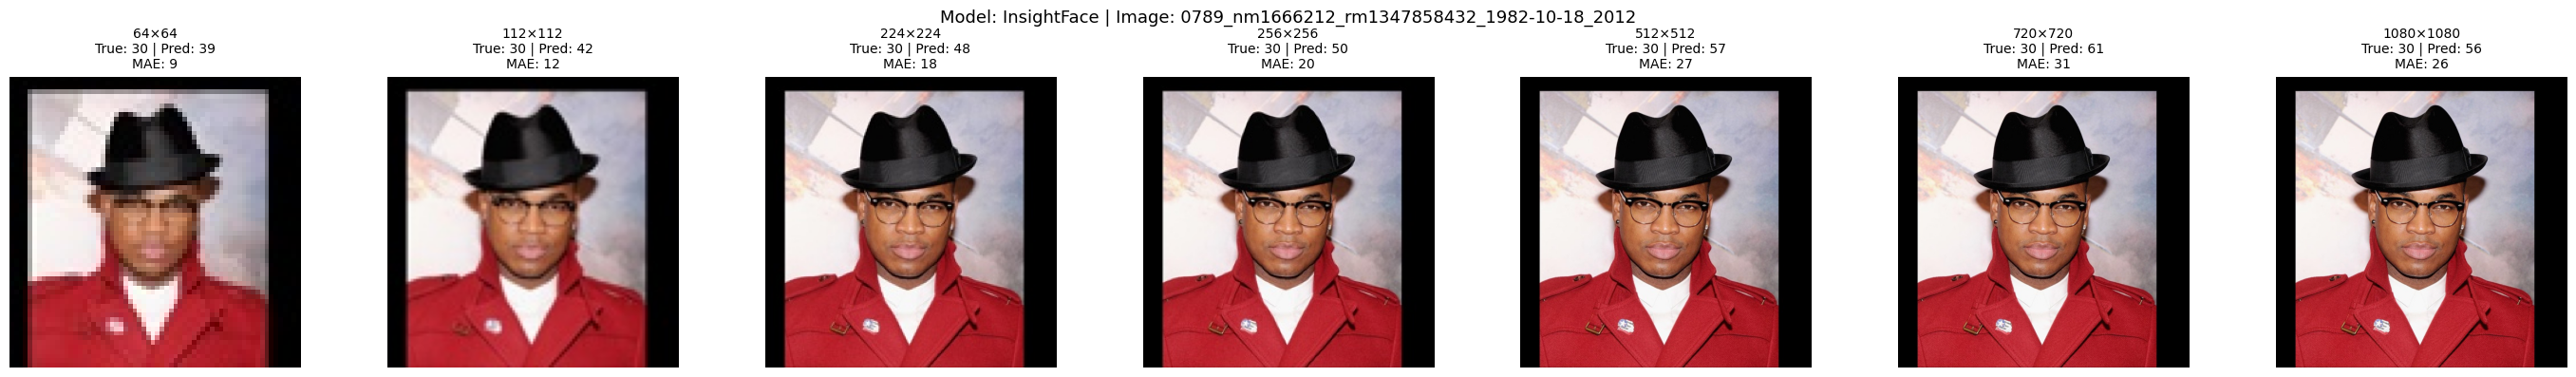

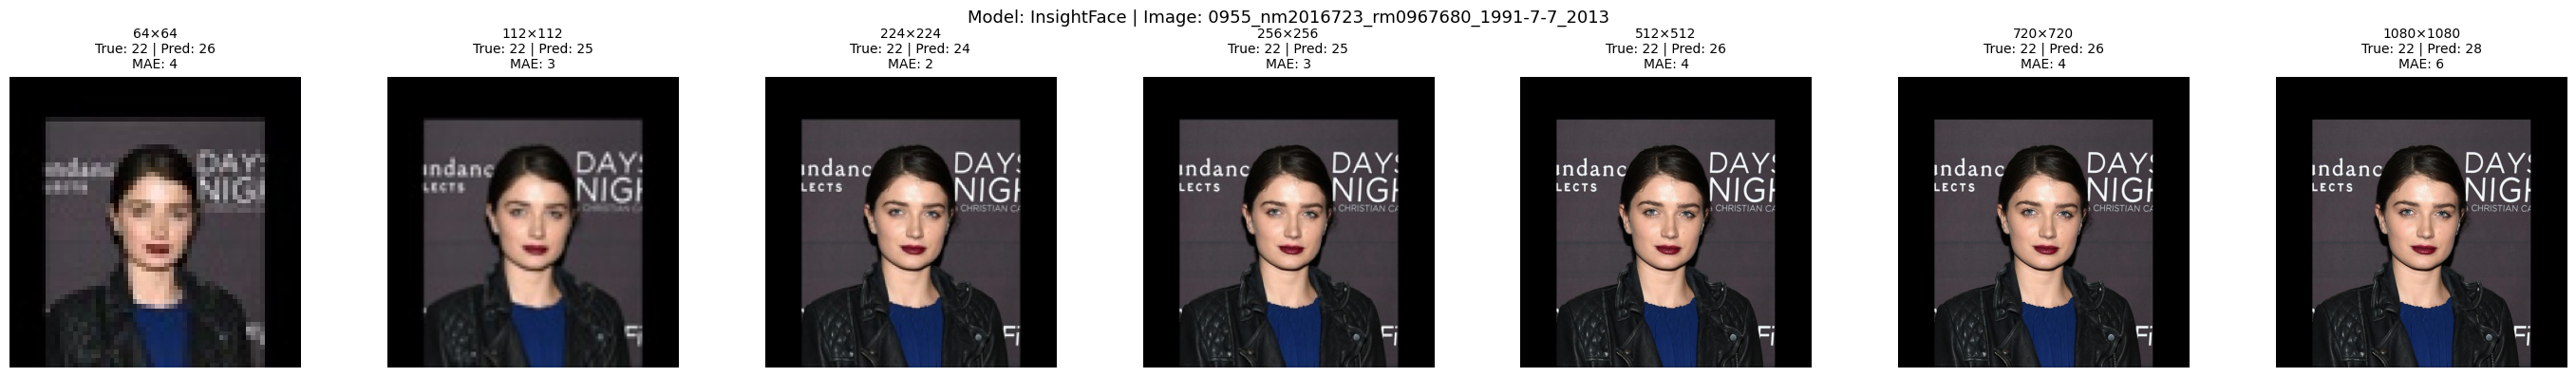

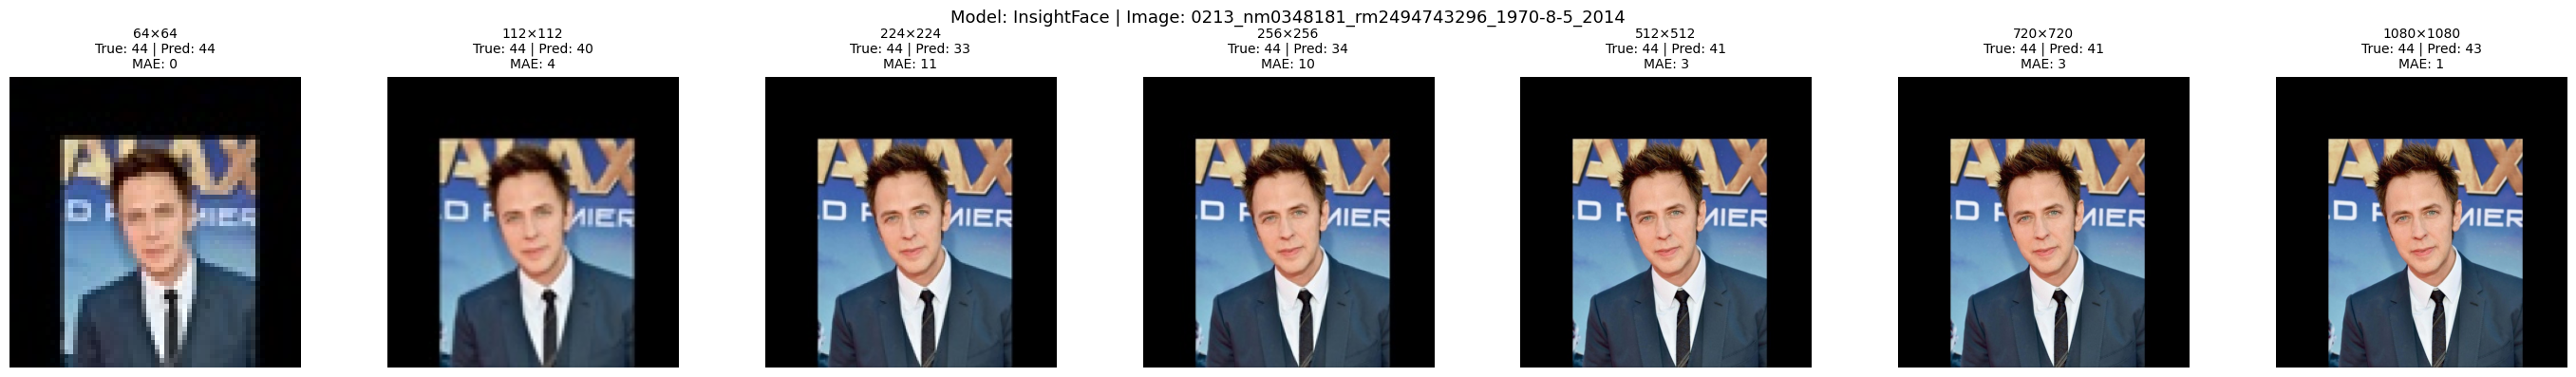

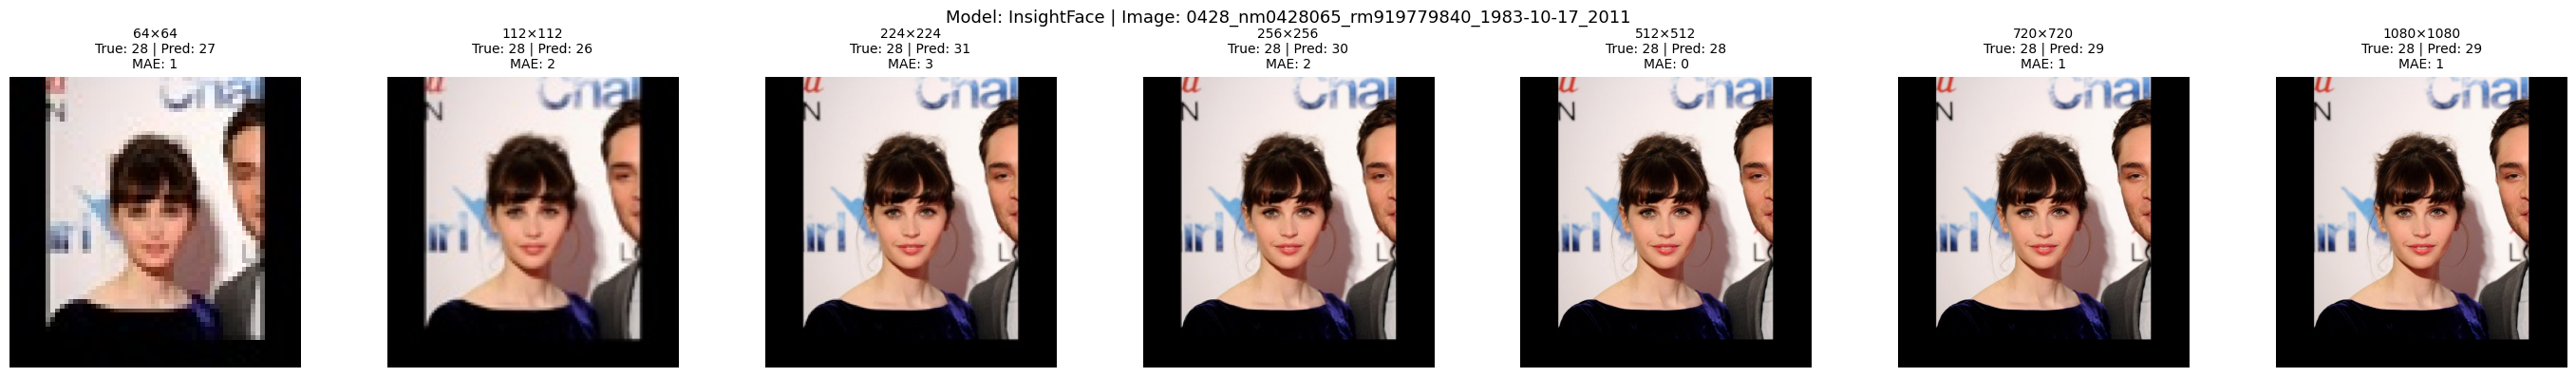

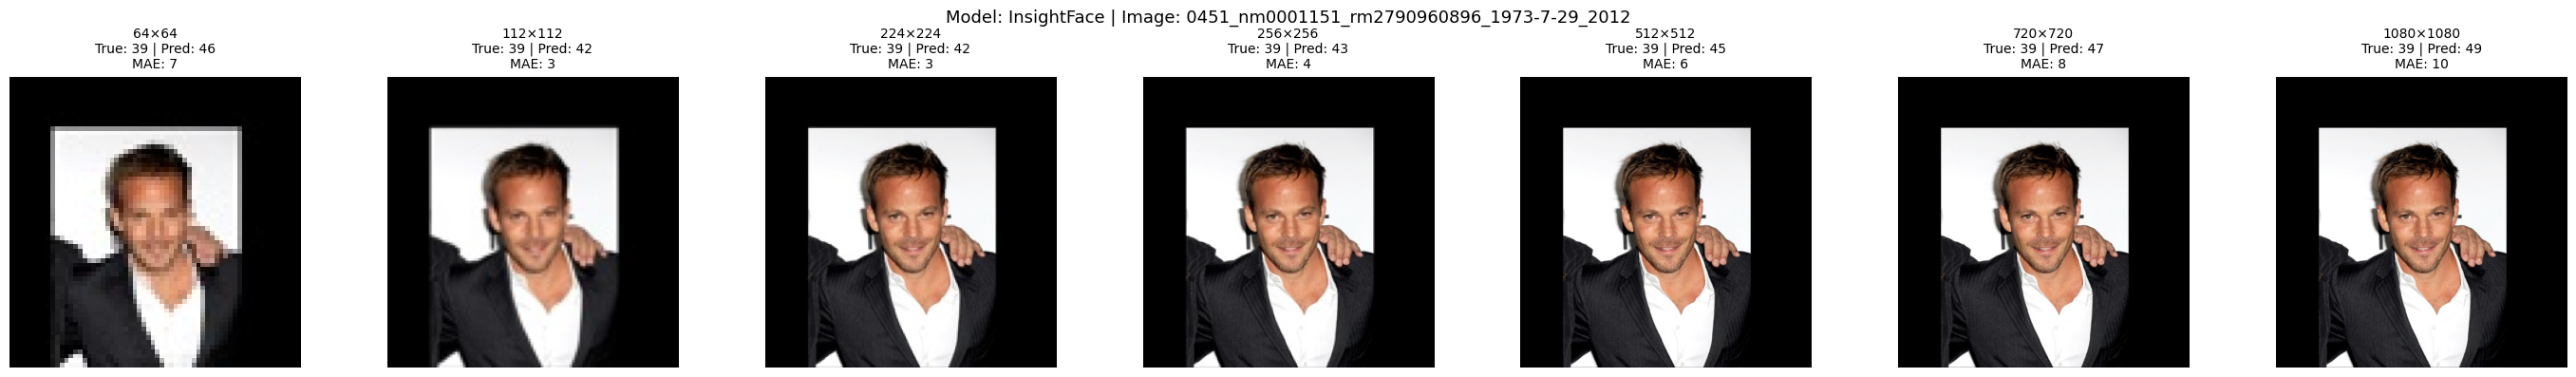

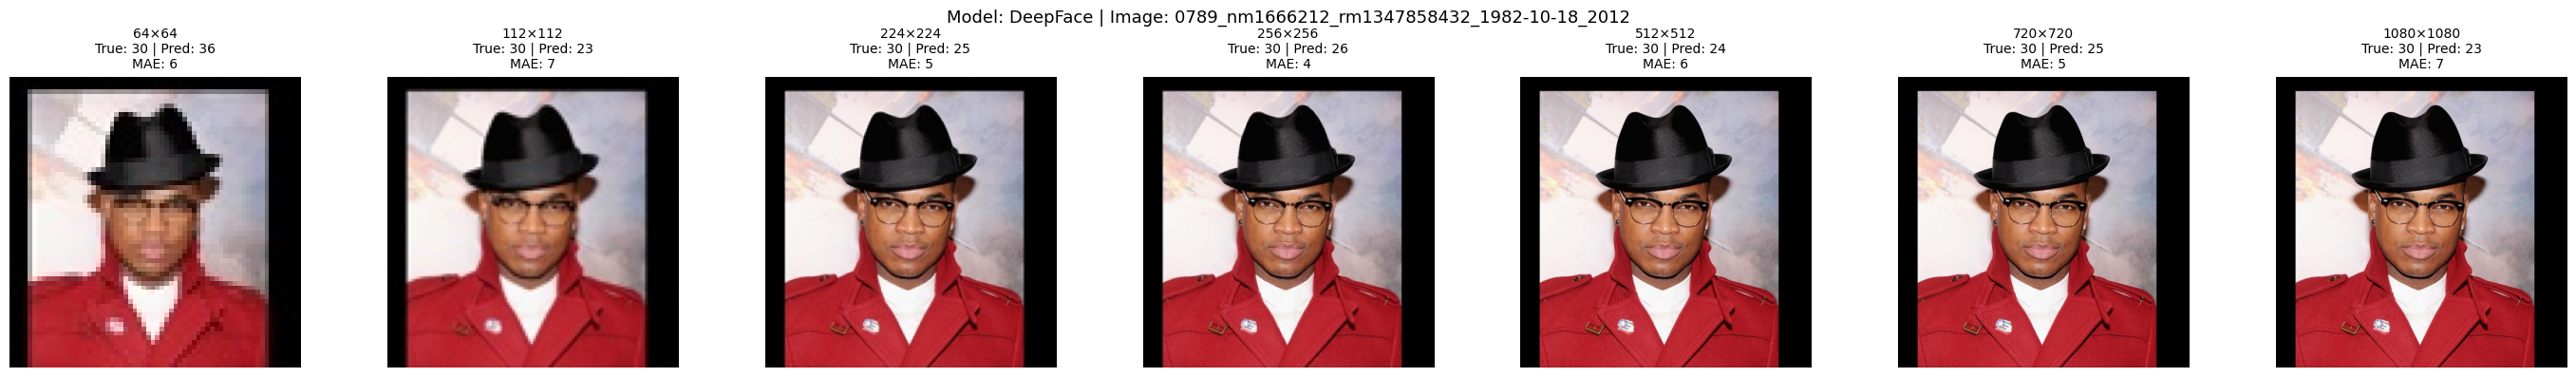

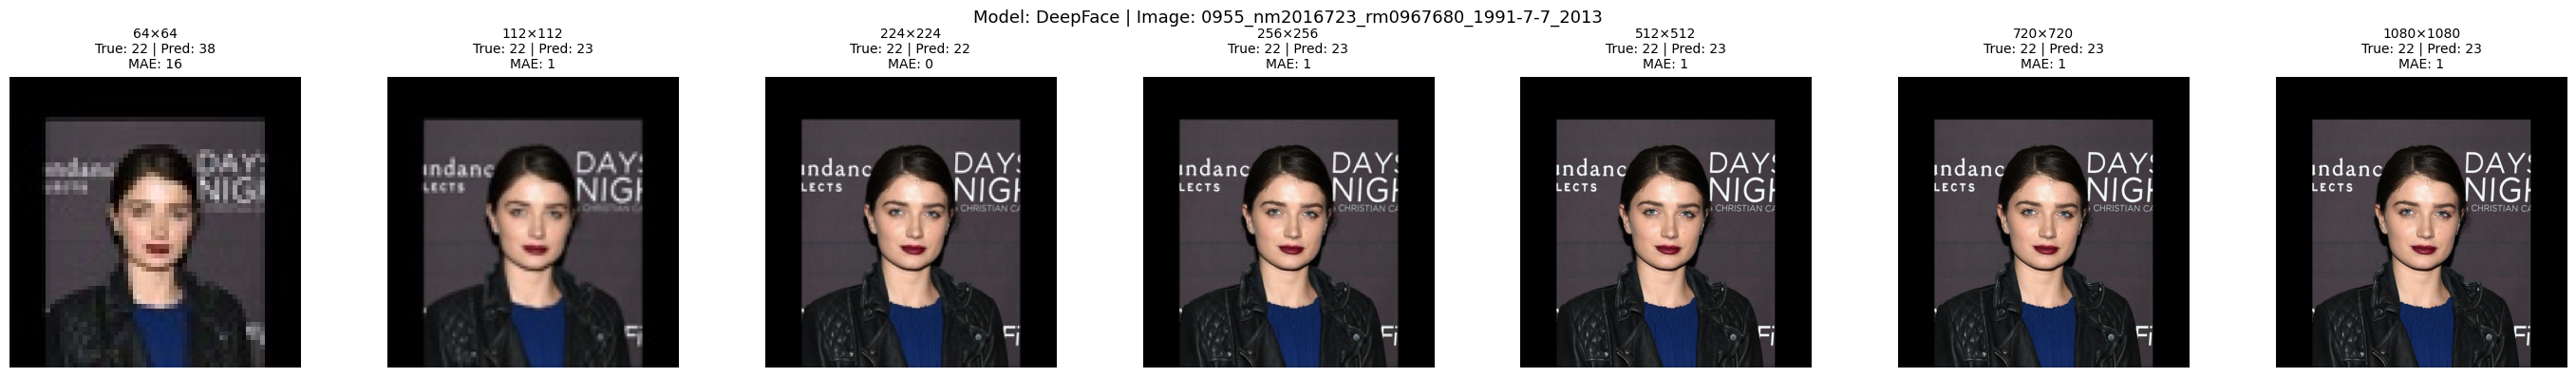

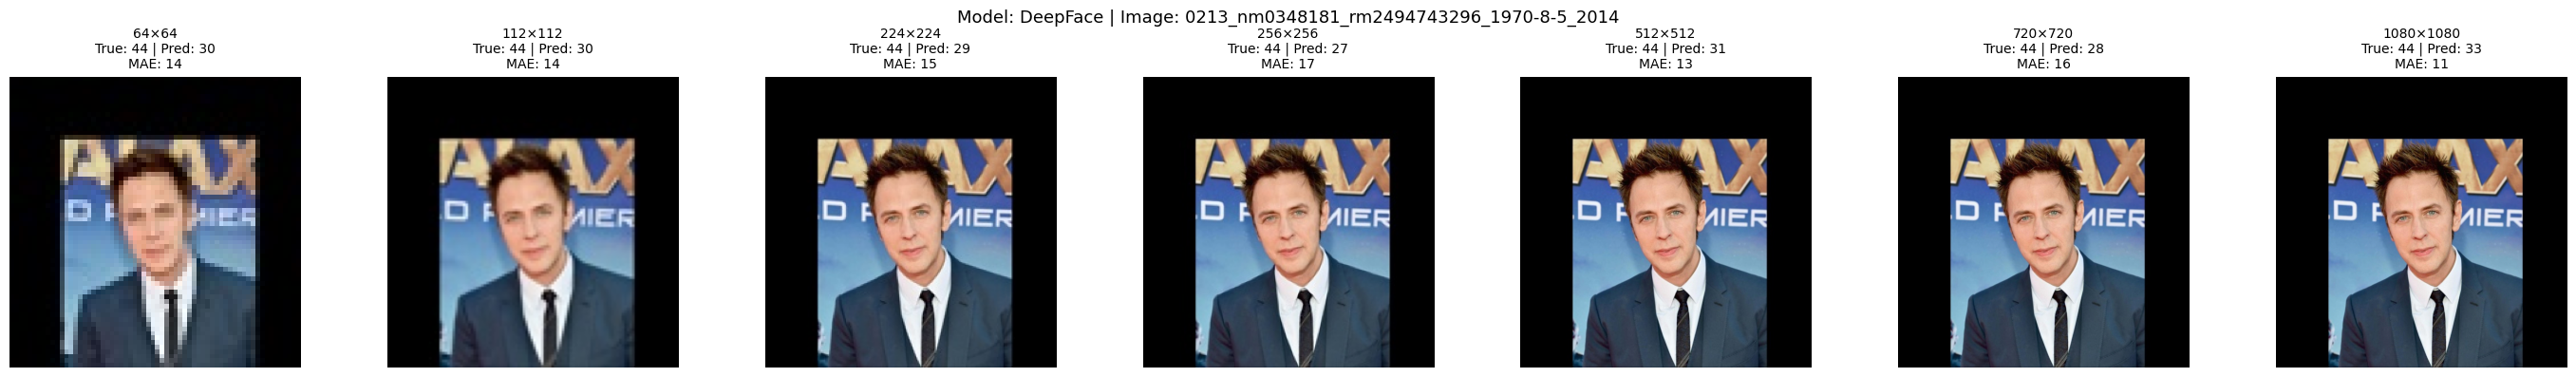

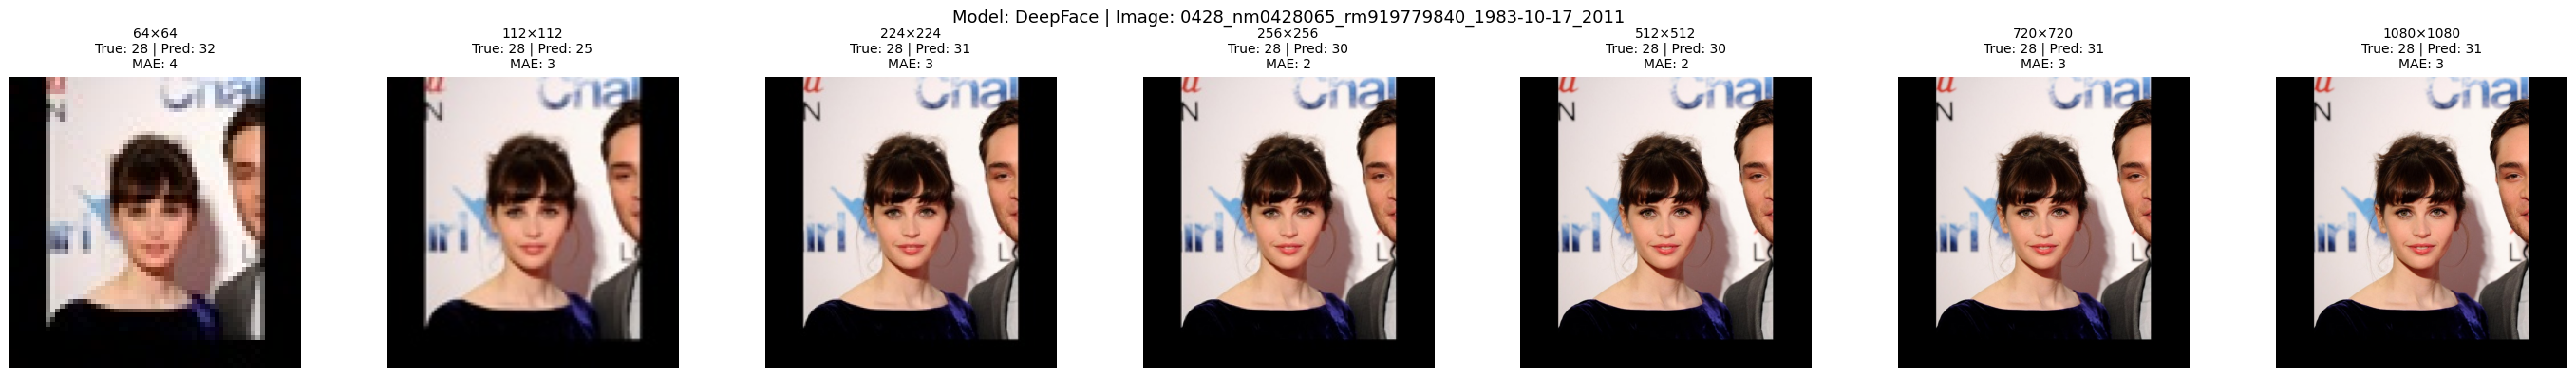

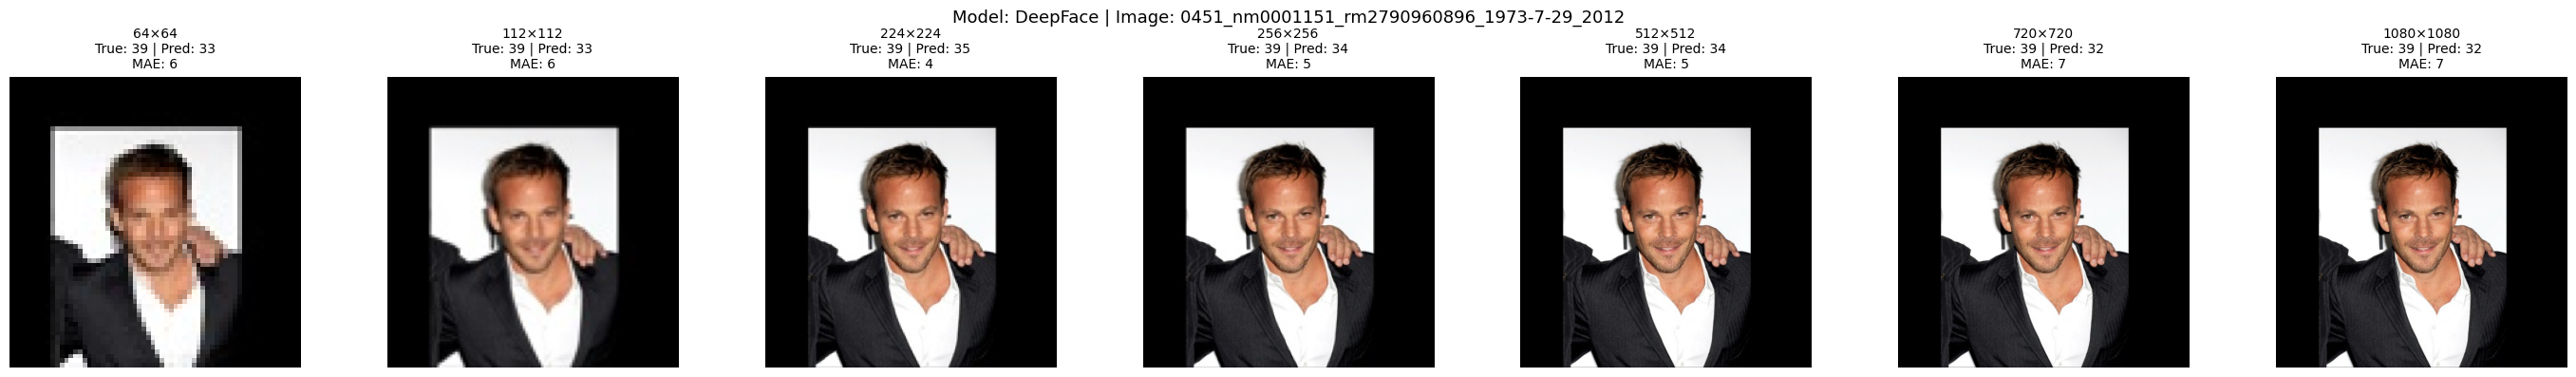

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
img_dir = "/content/resized_images"
csv_path = "per_photo_predictions.csv"
resolutions = ["64", "112", "224", "256", "512", "720", "1080"]

# === Load predictions CSV ===
df_photos = pd.read_csv(csv_path)
df_photos["res"] = df_photos["res"].astype(str)

# === Debug: check number of unique images per model ===
print("✅ Total rows in CSV:", len(df_photos))
print("✅ Unique images per model:")
print(df_photos.groupby("model")["filename"].nunique())

# === Function to show image grid for one model ===
def show_image_grid_per_model(df_photos, model_name, num_images=5):
    df_model = df_photos[df_photos["model"] == model_name]
    unique_filenames = df_model["filename"].unique()[:num_images]

    if len(unique_filenames) == 0:
        print(f"⚠️ No images found for model: {model_name}")
        return

    for fname in unique_filenames:
        df_img = df_model[df_model["filename"] == fname]
        fig, axs = plt.subplots(1, len(resolutions), figsize=(28, 4))
        fig.suptitle(f"Model: {model_name} | Image: {fname}", fontsize=13)

        for i, res in enumerate(resolutions):
            ax = axs[i]
            row = df_img[df_img["res"] == res]
            if row.empty:
                ax.axis("off")
                continue

            img_path = os.path.join(img_dir, f"{fname}_{res}.jpg")
            if not os.path.exists(img_path):
                print(f"⚠️ File not found: {img_path}")
                ax.axis("off")
                continue

            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
                ax.axis("off")

                true_age = int(row["true_age"].values[0])
                pred_age = int(row["pred_age"].values[0])
                mae = abs(true_age - pred_age)

                ax.set_title(
                    f"{res}×{res}\nTrue: {true_age} | Pred: {pred_age}\nMAE: {mae}",
                    fontsize=10
                )
            except Exception as e:
                print(f"❌ Error loading {img_path}: {e}")
                ax.axis("off")

        plt.tight_layout()
        plt.show()

# === Run for both models ===
show_image_grid_per_model(df_photos, "InsightFace", num_images=5)
show_image_grid_per_model(df_photos, "DeepFace", num_images=5)


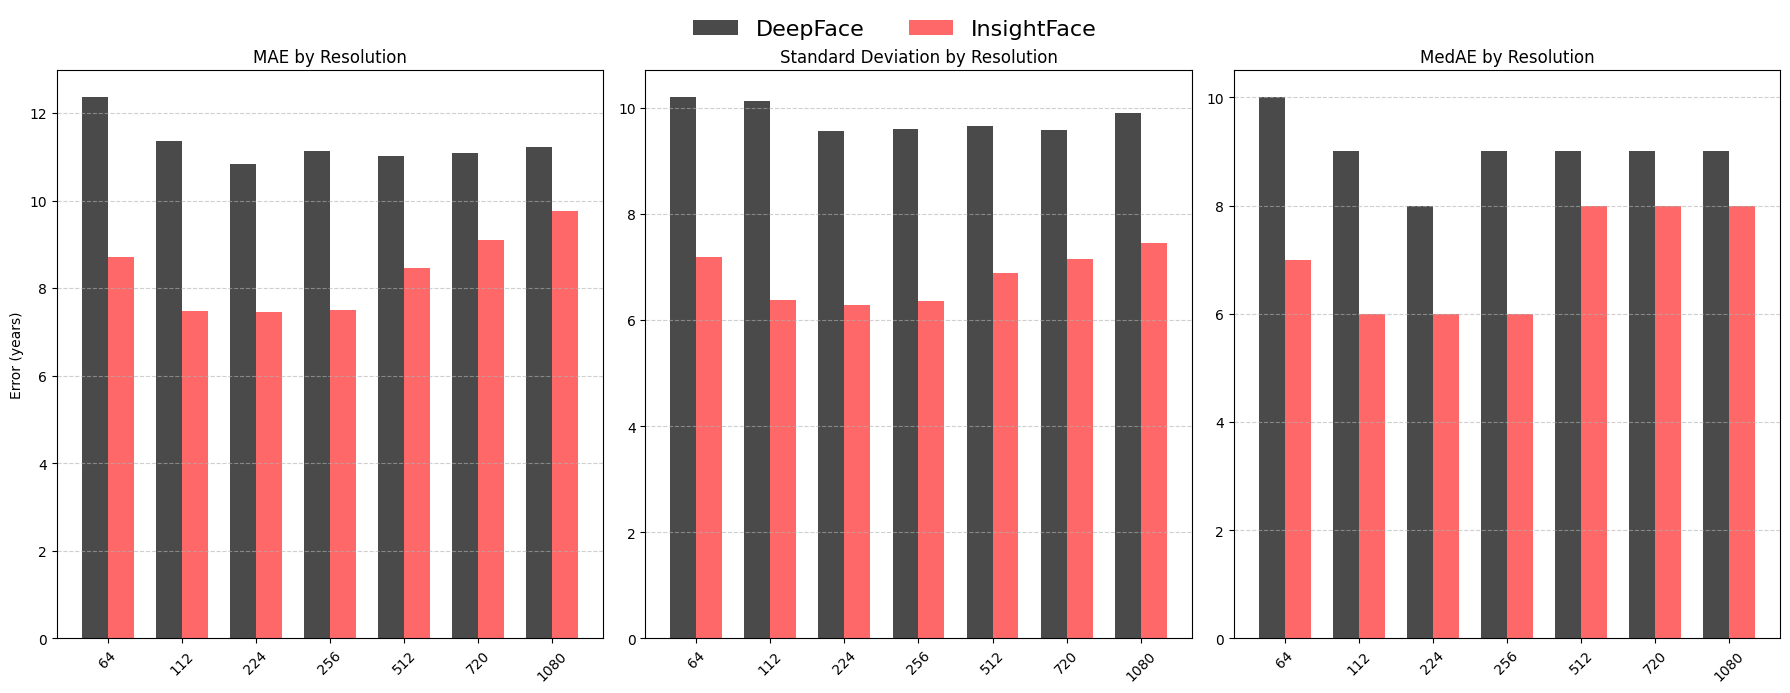

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load evaluation results
df_results = pd.read_csv("accuracy_metrics.csv")

# Set resolutions as x-axis labels
resolutions = df_results["Resolution"].astype(str)
x = np.arange(len(resolutions))  # X-axis positions
bar_width = 0.35

colors = ["#4A4A4A", "#FF6868"]

# Create figure with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharex=True)

# === 1. MAE Plot ===
axes[0].bar(x - bar_width/2, df_results["DeepFace_MAE"], width=bar_width, label="DeepFace", color=colors[0])
axes[0].bar(x + bar_width/2, df_results["InsightFace_MAE"], width=bar_width, label="InsightFace", color=colors[1])
axes[0].set_title("MAE by Resolution")
axes[0].set_ylabel("Error (years)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(resolutions, rotation=45)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# === 2. Standard Deviation Plot ===
axes[1].bar(x - bar_width/2, df_results["DeepFace_SD"], width=bar_width, color=colors[0])
axes[1].bar(x + bar_width/2, df_results["InsightFace_SD"], width=bar_width, color=colors[1])
axes[1].set_title("Standard Deviation by Resolution")
axes[1].set_xticks(x)
axes[1].set_xticklabels(resolutions, rotation=45)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

# === 3. MedAE Plot ===
axes[2].bar(x - bar_width/2, df_results["DeepFace_MedAE"], width=bar_width, color=colors[0])
axes[2].bar(x + bar_width/2, df_results["InsightFace_MedAE"], width=bar_width, color=colors[1])
axes[2].set_title("MedAE by Resolution")
axes[2].set_xticks(x)
axes[2].set_xticklabels(resolutions, rotation=45)
axes[2].grid(axis="y", linestyle="--", alpha=0.6)

# Add legend at the top center
fig.legend(["DeepFace", "InsightFace"], loc="upper center", ncol=2, frameon=False, fontsize=16)

# Adjust layout to make space for legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load accuracy results
df = pd.read_csv("accuracy_metrics.csv")

# Format resolution as "64×64", "112×112", etc.
def fmt_res(x):
    try:
        i = int(float(x))
        return f"{i}×{i}"
    except Exception:
        return str(x)

df["Resolution"] = df["Resolution"].apply(fmt_res)

# Find best resolution (lowest MAE) per framework
deep_idx = df["DeepFace_MAE"].idxmin()
ins_idx  = df["InsightFace_MAE"].idxmin()

# Create a summary table
summary = pd.DataFrame({
    "Framework": ["DeepFace", "InsightFace"],
    "Best Resolution": [df.loc[deep_idx, "Resolution"], df.loc[ins_idx, "Resolution"]],
    "MAE (↓)": [df.loc[deep_idx, "DeepFace_MAE"], df.loc[ins_idx, "InsightFace_MAE"]],
    "SD (↓)":  [df.loc[deep_idx, "DeepFace_SD"],  df.loc[ins_idx, "InsightFace_SD"]],
    "MedAE (↓)": [df.loc[deep_idx, "DeepFace_MedAE"], df.loc[ins_idx, "InsightFace_MedAE"]],
    "Avg. MAE (All Resolutions)": [df["DeepFace_MAE"].mean(), df["InsightFace_MAE"].mean()]
}).round(2)

# Clear text summary per framework
print(
    f"DeepFace → best at {summary.loc[0,'Best Resolution']} (MAE {summary.loc[0,'MAE (↓)']}, "
    f"SD {summary.loc[0,'SD (↓)']}, MedAE {summary.loc[0,'MedAE (↓)']}); "
    f"avg. MAE {summary.loc[0,'Avg. MAE (All Resolutions)']}."
)
print(
    f"InsightFace → best at {summary.loc[1,'Best Resolution']} (MAE {summary.loc[1,'MAE (↓)']}, "
    f"SD {summary.loc[1,'SD (↓)']}, MedAE {summary.loc[1,'MedAE (↓)']}); "
    f"avg. MAE {summary.loc[1,'Avg. MAE (All Resolutions)']}."
)

# Nicely formatted table for screenshot/export (e.g., in Jupyter or Colab)
try:
    from IPython.display import display
    display(
        summary.style
        .hide_index()
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            {"selector": "th", "props": [("background", "#1f2937"), ("color", "white"), ("text-align", "center")]},
            {"selector": "td", "props": [("border", "1px solid #e5e7eb"), ("padding", "6px 10px")]},
            {"selector": "tbody tr:nth-child(even)", "props": [("background", "#f9fafb")]}
        ])
    )
except Exception:
    # Fallback to plain text if display fails
    print("\nSummary Table:\n")
    print(summary.to_string(index=False))

# Optional: Export summary as LaTeX table
with open("summary_best_resolutions.tex", "w") as f:
    f.write(summary.to_latex(index=False, column_format="lccccc"))

print("✅ Summary saved as summary_best_resolutions.tex")


DeepFace → best at 224×224 (MAE 10.83, SD 9.57, MedAE 8.0); avg. MAE 11.28.
InsightFace → best at 224×224 (MAE 7.46, SD 6.28, MedAE 6.0); avg. MAE 8.35.

Summary Table:

  Framework Best Resolution  MAE (↓)  SD (↓)  MedAE (↓)  Avg. MAE (All Resolutions)
   DeepFace         224×224    10.83    9.57        8.0                       11.28
InsightFace         224×224     7.46    6.28        6.0                        8.35
✅ Summary saved as summary_best_resolutions.tex


In [ ]:
import pandas as pd

# Load evaluation results
df = pd.read_csv("accuracy_metrics.csv")

# Format resolution as LaTeX math (e.g., 64×64 → $64 \times 64$)
df["Resolution"] = df["Resolution"].apply(lambda x: f"${int(x)} \\times {int(x)}$")

# Reorder and round columns for LaTeX table
df_latex = df[[
    "Resolution",
    "DeepFace_MAE", "DeepFace_SD", "DeepFace_MedAE",
    "InsightFace_MAE", "InsightFace_SD", "InsightFace_MedAE"
]].round(2)

# Build LaTeX table header
latex_code = r"""
\begin{table}[h]
\centering
\caption{Mean Absolute Error (MAE), Standard Deviation (SD), and Median Absolute Error (MedAE) per resolution for DeepFace and InsightFace.}
\label{tab:accuracy_metrics}
\renewcommand{\arraystretch}{1.2}
\begin{tabular}{|c|ccc|ccc|}
\hline
\multirow{2}{*}{\textbf{Resolution}} & \multicolumn{3}{c|}{\textbf{DeepFace}} & \multicolumn{3}{c|}{\textbf{InsightFace}} \\
 & MAE ↓ & SD ↓ & MedAE ↓ & MAE ↓ & SD ↓ & MedAE ↓ \\
\hline
"""

# Add rows to the LaTeX table
for _, row in df_latex.iterrows():
    latex_code += f"{row['Resolution']} & {row['DeepFace_MAE']} & {row['DeepFace_SD']} & {row['DeepFace_MedAE']} & {row['InsightFace_MAE']} & {row['InsightFace_SD']} & {row['InsightFace_MedAE']} \\\\\n"

# Close LaTeX table
latex_code += r"""\hline
\end{tabular}
\end{table}
"""

# Save LaTeX code to file
with open("accuracy_metrics_table.tex", "w") as f:
    f.write(latex_code)


In [ ]:
import time
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from deepface import DeepFace
from insightface.app import FaceAnalysis
import matplotlib.pyplot as plt

# === Configuration ===
image_dir = "/content/resized_images"
resolutions = ["64", "112", "224", "256", "512", "720", "1080"]

repeats = 10                     # number of repeated runs per image
images_per_resolution = 100       # number of images sampled per resolution
models = ["DeepFace", "InsightFace"]

# === Initialize InsightFace ===
insightface = FaceAnalysis(allowed_modules=["detection", "genderage"])
insightface.prepare(ctx_id=0)

def measure_inference_time(model, image_paths, resolution):
    """Measure mean and standard deviation of inference time per image."""
    per_image_means = []
    per_image_stds = []

    desc = f"{model} {resolution}"
    with tqdm(total=len(image_paths) * repeats, desc=desc, unit="img") as pbar:
        for path in image_paths:
            timings = []
            for _ in range(repeats):
                start = time.perf_counter()

                if model == "DeepFace":
                    # Run DeepFace age estimation
                    DeepFace.analyze(img_path=path, actions=["age"], enforce_detection=False)
                else:
                    # Run InsightFace age estimation
                    img = cv2.imread(path)
                    age_list = insightface.get(img)
                    if not age_list:
                        continue
                    _ = age_list[0]["age"]

                end = time.perf_counter()
                timings.append(end - start)
                pbar.update(1)

            # Store per-image mean and std only if valid timings exist
            if timings:
                per_image_means.append(np.mean(timings))
                per_image_stds.append(np.std(timings))

    # Compute mean and std across all images for this resolution/model
    mean = np.mean(per_image_means)
    std = np.mean(per_image_stds)
    return mean, std

# === Run measurements ===
results = []

for resolution in resolutions:
    # Select sample images for this resolution
    image_paths = sorted([
        os.path.join(image_dir, f)
        for f in os.listdir(image_dir)
        if f.endswith(f"_{resolution}.jpg")
    ])[:images_per_resolution]

    # Measure both models
    for model in models:
        avg_time, std_time = measure_inference_time(model, image_paths, resolution)
        results.append({
            "Resolution": f"{resolution}×{resolution}",
            f"Mean ({model})": f"{round(avg_time, 3)}s",
            f"± Std Dev ({model})": f"{round(std_time, 3)}s",
        })

# === Format final table ===
summary = {}
for entry in results:
    res = entry["Resolution"]
    if res not in summary:
        summary[res] = {"Resolution": res}
    for k, v in entry.items():
        if k != "Resolution":
            summary[res][k] = v

# Create final DataFrame and save
df_final = pd.DataFrame(list(summary.values()))
df_final.to_csv("inference_time_summary.csv", index=False)
print("\nSaved to inference_time_summary.csv")
print(df_final.to_markdown(index=False))


25-10-28 11:07:48 - Directory /root/.deepface has been created
25-10-28 11:07:48 - Directory /root/.deepface/weights has been created
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
model ignore: /root/.insightface/models/buffalo

DeepFace 64:   0%|          | 0/1000 [00:00<?, ?img/s]

25-10-28 11:07:50 - 🔗 age_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5 to /root/.deepface/weights/age_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  2%|▏         | 11.0M/539M [00:00<00:12, 41.3MB/s]
  4%|▍         | 21.5M/539M [00:00<00:13, 38.0MB/s]
  6%|▌         | 32.0M/539M [00:00<00:13, 37.5MB/s]
  8%|▊         | 42.5M/539M [00:01<00:13, 37.6MB/s]
 10%|▉         | 53.0M/539M [00:01<00:12, 38.4MB/s]
 12%|█▏        | 63.4M/539M [00:01<00:12, 37.4MB/s]
 14%|█▎        | 73.9M/539M [00:01<00:12, 36.7MB/s]
 16%|█▌        | 84.4M/539M [00:02<00:12, 35.9MB/s]
 18%|█▊        | 94.9M/539M [00:02<00:12, 35.6MB/s]
 20%|█▉        | 105M/539M [00:02<00:12, 34.9MB/s] 
 22%|██▏       | 116M/539M [00:03<00:13, 30.3MB/s]
 23%|██▎       | 126M/539M [00:03<00:13, 31.0MB/s]
 25%|██▌       | 137M/539M [00:03<00:12, 32.9MB/s]
 27%|██▋       | 147M/539M [00:04<00:11, 33.8MB/s]
 29%|██▉       | 158M/539M [00:04<00:11, 34.0MB/s]
 31%|███       | 168M/5


Saved to inference_time_summary.csv
| Resolution   | Mean (DeepFace)   | ± Std Dev (DeepFace)   | Mean (InsightFace)   | ± Std Dev (InsightFace)   |
|:-------------|:------------------|:-----------------------|:---------------------|:--------------------------|
| 64×64        | 0.052s            | 0.07s                  | 0.016s               | 0.006s                    |
| 112×112      | 0.039s            | 0.002s                 | 0.015s               | 0.001s                    |
| 224×224      | 0.074s            | 0.005s                 | 0.016s               | 0.001s                    |
| 256×256      | 0.086s            | 0.007s                 | 0.016s               | 0.001s                    |
| 512×512      | 0.222s            | 0.022s                 | 0.017s               | 0.001s                    |
| 720×720      | 0.381s            | 0.044s                 | 0.019s               | 0.001s                    |
| 1080×1080    | 0.733s            | 0.106s                

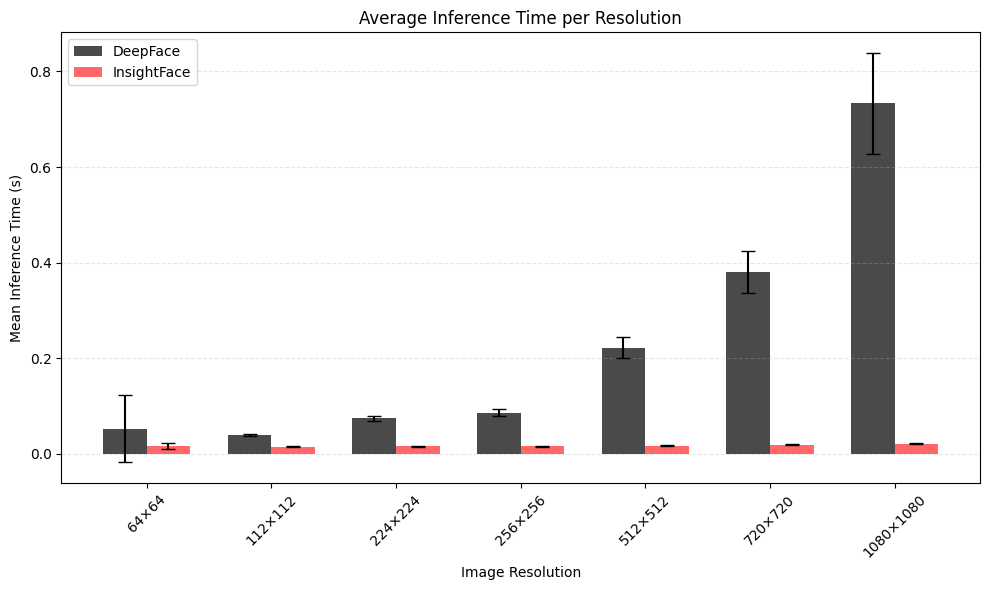

In [ ]:

# --- Clean values ---
df_plot = df_final.copy()
for col in df_plot.columns:
    if col != "Resolution":
        df_plot[col] = df_plot[col].str.replace("s", "").astype(float)

# --- Plot settings ---
x = df_plot["Resolution"]
width = 0.35
x_indexes = np.arange(len(x))
colors = ["#4A4A4A", "#FF6868"]  # DeepFace = donkergrijs, InsightFace = rood

# --- Create the plot ---
plt.figure(figsize=(10, 6))

plt.bar(
    x_indexes - width/2,
    df_plot["Mean (DeepFace)"],
    width=width,
    label="DeepFace",
    color=colors[0],
    yerr=df_plot["± Std Dev (DeepFace)"],
    capsize=5
)
plt.bar(
    x_indexes + width/2,
    df_plot["Mean (InsightFace)"],
    width=width,
    label="InsightFace",
    color=colors[1],
    yerr=df_plot["± Std Dev (InsightFace)"],
    capsize=5
)


plt.xticks(ticks=x_indexes, labels=x, rotation=45)
plt.xlabel("Image Resolution")
plt.ylabel("Mean Inference Time (s)")
plt.title("Average Inference Time per Resolution")
plt.legend()
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.savefig("inference_times_plot.png", dpi=600)
plt.show()


In [ ]:
col_format = "|" + "|".join(["c"] * len(df_final.columns)) + "|"

with open("inference_time_table.tex", "w") as f:
    f.write(df_final.to_latex(
        index=False,
        caption=("Gemiddelde inferentietijd per model bij verschillende resoluties "
                 f"({images_per_resolution} afbeeldingen, {repeats} herhalingen per afbeelding)."),
        label="tab:runtime",
        column_format=col_format,
        escape=False
    ))
